### Deep Learning Assignment - Group 255

| Name | StudentID  | Contribution  | 
|:--|:--|--:|
| AMOGH SINGHAL | 2020SC04081 | 100% |
| ABHAY DATTARAY THAPAN | 2020SC04431 | 100% |
| AKSHIT AGRAWAL | 2020SC04956 | 100% |

#####  1. Load the attached csv file in python. Each row consists of feature 1, feature 2, & class label.

In [5]:
# Run this to connect Google Drive to read files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import pandas as pd
import seaborn as sns
# path to spiral dataset
URL = "/content/drive/MyDrive/Colab Notebooks/spiral_data/data2_0.75_6.csv"

# since we don't have named columns, we are passing them explicitly
# Features : X1 , X2
# Class: class (target variable)
df = pd.read_csv(URL, names=["X1", "X2", "class"], header=None)
df 

,X1,X2,class
0,0.156327,1.185676e-02,0
1,0.211109,3.220876e-02,0
2,0.263386,6.086580e-02,0
3,0.312221,9.754146e-02,0
4,0.356707,1.418555e-01,0
...,...,...,...
493,-13.181762,4.118132e+00,1
494,-13.510777,3.122201e+00,1
495,-13.764337,2.100020e+00,1
496,-13.940352,1.057319e+00,1


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
X1,498.0,3.114049e-02,5.797450,-13.940352,-3.640488,5.391140e-02,3.705736,15.607963
X2,498.0,2.811015e-11,5.765504,-13.080541,-3.583832,3.684670e-15,3.470225,12.880863
class,498.0,5.020080e-01,0.500499,0.000000,0.000000,1.000000e+00,1.000000,1.000000


Observing dataset for patterns
* Scatterplots between features and target
* Scatterplots within features

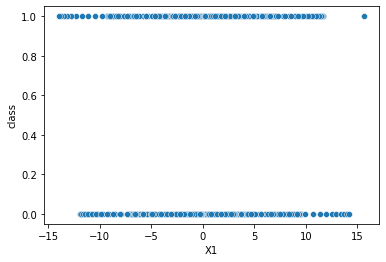

In [ ]:
# no significant pattern observed
sns.scatterplot(x="X1", y="class", data=df)

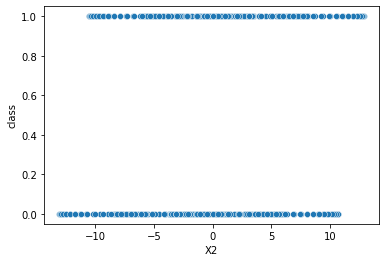

In [ ]:
# no significant pattern observed
sns.scatterplot(x="X2", y="class", data=df)

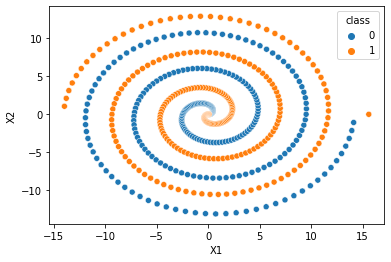

In [ ]:
# we observe a spiral like structure
sns.scatterplot(x="X1", y="X2", data=df, hue="class")

* The spiral dataset as observed is not `linearly seperable`
* Building a classifier for this would be a challenge

### Visualising the target class

In [ ]:
df.info()
# We don't have null values in any of the columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X1      498 non-null    float64
 1   X2      498 non-null    float64
 2   class   498 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 11.8 KB


In [ ]:
df['class'].value_counts()
# This is a binary classification problem

1    250
0    248
Name: class, dtype: int64

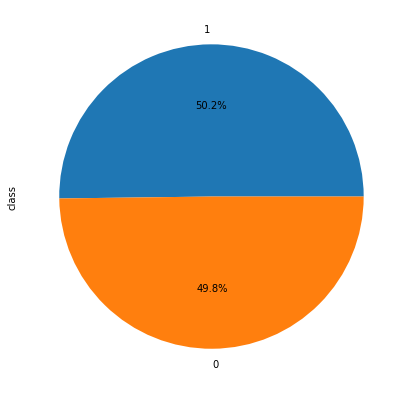

In [ ]:
def plot_pie(dataset, target, size=(7,7)):
    return dataset[target].value_counts().plot.pie(autopct = '%1.1f%%', figsize=size)

plot_pie(df, 'class')
# The data is fairly balanced

2.Train two single/double hidden layer deep networks by varying the number of hidden nodes (4, 8, 12, 16) in each layer with 70% training and 30% validation data. 

Use appropriate learning rate, activation, and loss functions and also mention the reason for choosing the same. 

Report, compare, and explain the observed accuracy and minimum loss achieved. **[0.5+1 mark]**

In [6]:
from tensorflow import keras, random
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L2
from keras.optimizers import adam_v2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Since we require to make different models with different configurations
# We have designed a class to enforce DRY principles of software engineering

class ModelMaker():

  def __init__(self, hidden_layers=1, hidden_nodes=4, transform=False):
    """
    This function will prepare a Sequential model
    according to input configuration

    hidden_layers -> Int : number of hidden layers in network
    hidden_layers -> Int : number of nodes in each hidden layer
    return -> None
    """
    self.hidden_layers = hidden_layers
    self.hidden_nodes = hidden_nodes
    
    self.model = None
    self.X = None
    self.y = None

    print(f"Number of hidden layers: {self.hidden_layers}")
    print(f"Number of nodes in each hidden layer: {self.hidden_nodes}")

    # setting the random seed to provide identical simulations
    random.set_seed(42)
    model = Sequential()
    opt = adam_v2.Adam(learning_rate=0.001)
    
    # input layer
    if transform:
      model.add(Dense(8, input_shape=(7,), activation='relu'))
    else:
      model.add(Dense(8, input_shape=(2,), activation='relu'))
    
    # hidden layer(s) -- ReLU is less susceptible to vanishing gradients
    # L2 regularization is used because it is computationally less expensive
    # and it uses Euclidean distance which is having a unique solution
    for l in range(0, self.hidden_layers):
      model.add(Dense(self.hidden_nodes, activation='relu', activity_regularizer=L2(0.001)))
    
    # output layer -- binary classification hence sigmoid is chose
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the keras model
    # Loss function : Binary Cross-Entropy intended for binary classification
    # because it is equivalent to fitting the model 
    # using maximum likelihood estimation
    model.compile(loss='binary_crossentropy', 
                  optimizer=opt,
                  metrics=['accuracy'])

    # set the instance to trained model
    self.model = model
    print(self.model.summary())

  def prepare_data(self, dataset):
    """
    This function will extract features and labels.
    Additionaly it will split the training and validation data
    
    dataset -> pd.DataFrame : dataset
    return -> train and val tuple : (X_train, X_val, y_train, y_val)
    """

    print("Preparing dataset...")
    # since we have two columns as features, we extract them using `iloc`
    self.y = dataset['class']
    self.X = dataset.drop('class', axis=1)


    print(f"Features are:{self.X.columns}")

    X_train, X_val, y_train, y_val = train_test_split(self.X, self.y, test_size=0.30)
    return X_train, X_val, y_train, y_val
  


  def train_model(self, train_X, train_y, epochs=1000, batch_size=32):
    """
    This function will train the model based on input
    epochs and batch_size. Additionaly it will plot the loss and
    accuracy curves of the model

    train_X -> pd.DataFrame : training features
    train_y -> pd.Series : training labels
    epoch -> Int : number of samples processed before the model is updated
    batch_size -> Int : number of complete passes through the training dataset

    return -> None
    """
    print("Training model...")
    # we split the training and validation as 70:30 here
    # verbose will help us see the progress of training
    history = self.model.fit(train_X, 
                             train_y, 
                             epochs=epochs, 
                             batch_size=batch_size,
                             validation_split=0.3, 
                             verbose=1)
    
    last_10_prc = int(epochs * 0.10)

    # we display the avg. loss and accuracy for last 10% epochs
    for k,v in history.history.items():
      print(f"Avg. {k} for last {last_10_prc} epochs", 
            np.round(np.mean(v[:-last_10_prc]),4))
        
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model Accuracy -- Layers {self.hidden_layers} -- Nodes {self.hidden_nodes}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model Loss -- Layers {self.hidden_layers} -- Nodes {self.hidden_nodes}')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
  
  def predict(self, val_X, val_y):
    """
    This function will evaluate the model based on validation data
    and print the classification report & confusion matrix for display

    val_X -> pd.DataFrame : validation features
    val_y -> pd.Series : validation labels

    return -> None
    """
    print("Running predictions...")
    
    # Encoding the predictions as 0 and 1 against the threshold
    predictions = (self.model.predict(val_X) > 0.5).astype(int)
    
    print('\n Validation Classification Report\n', classification_report(val_y, predictions))
    
    # plotting the confusion matrix
    conf_mat = confusion_matrix(val_y,predictions)

    # displaying the matrix as percentage
    ax = sns.heatmap(conf_mat/np.sum(conf_mat), 
                     annot=True, 
                     fmt='.2%', 
                     cmap='Blues')

    ax.set_title(f'Validation Confusion Matrix Layers {self.hidden_layers} -- Nodes {self.hidden_nodes} \n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    CLASSES = ['0', '1']

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(CLASSES)
    ax.yaxis.set_ticklabels(CLASSES)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    
    return predictions

Number of hidden layers: 2
Number of nodes in each hidden layer: 16
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_28 (Dense)            (None, 8)                 24        
                                                                 
 dense_29 (Dense)            (None, 16)                144       
                                                                 
 dense_30 (Dense)            (None, 16)                272       
                                                                 
 dense_31 (Dense)            (None, 1)                 17        
                                                                 
Total params: 457
Trainable params: 457
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2'], dtype='object')
Training model...
Epoch 1/1000
8/8 [=========

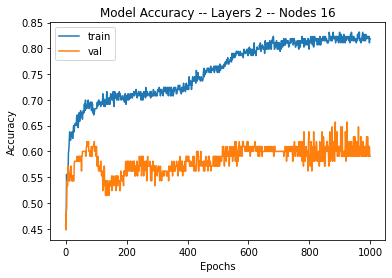

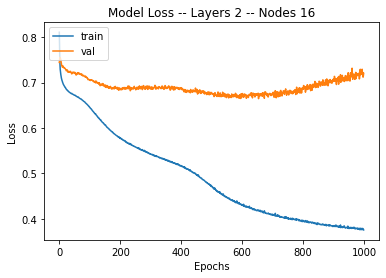

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.58      0.60      0.59        70
           1       0.64      0.62      0.63        80

    accuracy                           0.61       150
   macro avg       0.61      0.61      0.61       150
weighted avg       0.61      0.61      0.61       150



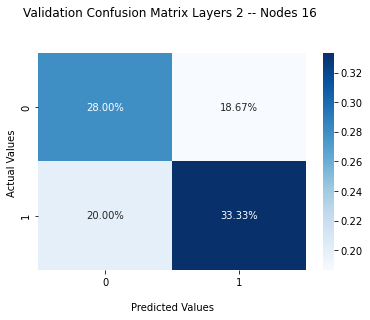

CPU times: user 1min 9s, sys: 6.05 s, total: 1min 15s
Wall time: 2min 23s


In [ ]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(2, 16)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 2
Number of nodes in each hidden layer: 12
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 8)                 24        
                                                                 
 dense_33 (Dense)            (None, 12)                108       
                                                                 
 dense_34 (Dense)            (None, 12)                156       
                                                                 
 dense_35 (Dense)            (None, 1)                 13        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2'], dtype='object')
Training model...
Epoch 1/1000
8/8 [=========

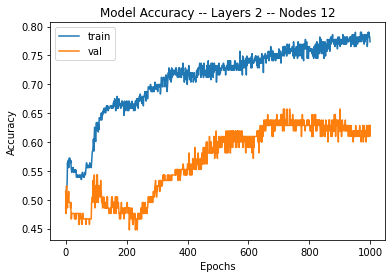

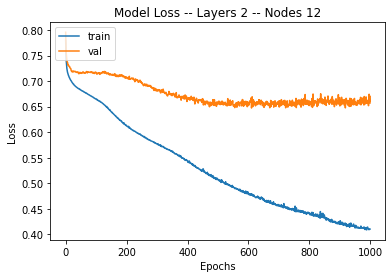

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.59      0.63      0.61        65
           1       0.70      0.67      0.69        85

    accuracy                           0.65       150
   macro avg       0.65      0.65      0.65       150
weighted avg       0.66      0.65      0.65       150



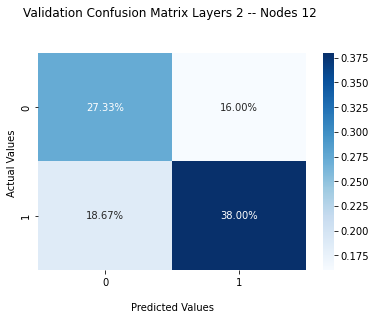

CPU times: user 1min 5s, sys: 6.04 s, total: 1min 11s
Wall time: 1min 14s


In [ ]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(2, 12)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 2
Number of nodes in each hidden layer: 8
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 8)                 24        
                                                                 
 dense_37 (Dense)            (None, 8)                 72        
                                                                 
 dense_38 (Dense)            (None, 8)                 72        
                                                                 
 dense_39 (Dense)            (None, 1)                 9         
                                                                 
Total params: 177
Trainable params: 177
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2'], dtype='object')
Training model...
Epoch 1/1000
8/8 [=========

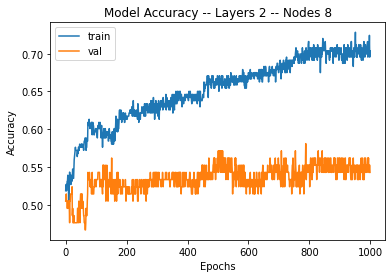

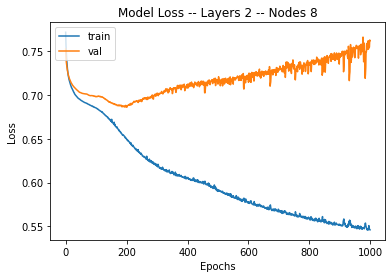

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.55      0.65      0.60        77
           1       0.54      0.44      0.48        73

    accuracy                           0.55       150
   macro avg       0.55      0.54      0.54       150
weighted avg       0.55      0.55      0.54       150



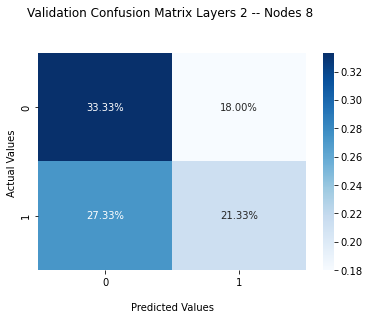

CPU times: user 1min 6s, sys: 6.14 s, total: 1min 12s
Wall time: 1min 17s


In [ ]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(2, 8)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 2
Number of nodes in each hidden layer: 4
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 8)                 24        
                                                                 
 dense_41 (Dense)            (None, 4)                 36        
                                                                 
 dense_42 (Dense)            (None, 4)                 20        
                                                                 
 dense_43 (Dense)            (None, 1)                 5         
                                                                 
Total params: 85
Trainable params: 85
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2'], dtype='object')
Training model...
Epoch 1/1000
8/8 [===========

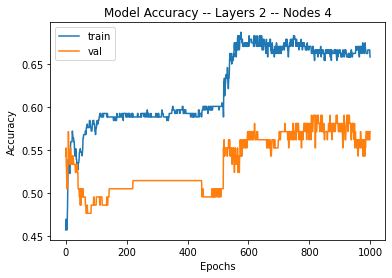

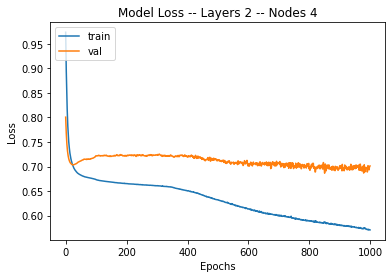

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.58      0.54      0.55        71
           1       0.61      0.65      0.63        79

    accuracy                           0.59       150
   macro avg       0.59      0.59      0.59       150
weighted avg       0.59      0.59      0.59       150



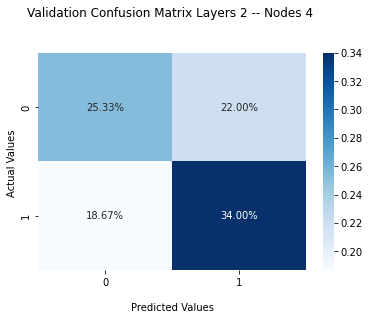

CPU times: user 1min 6s, sys: 6.32 s, total: 1min 13s
Wall time: 1min 23s


In [ ]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(2, 4)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 1
Number of nodes in each hidden layer: 16
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 8)                 24        
                                                                 
 dense_45 (Dense)            (None, 16)                144       
                                                                 
 dense_46 (Dense)            (None, 1)                 17        
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2'], dtype='object')
Training model...
Epoch 1/1000
8/8 [==============================] - 1s 27ms/step - loss: 0.8891 - accuracy: 0.5350 - val_loss: 0.9103 - val_accuracy: 0.5048
Epoch 2/1000
8/8 

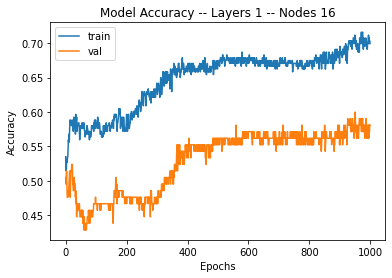

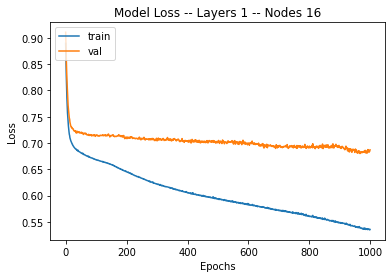

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.54      0.66      0.60        74
           1       0.58      0.46      0.51        76

    accuracy                           0.56       150
   macro avg       0.56      0.56      0.56       150
weighted avg       0.56      0.56      0.56       150



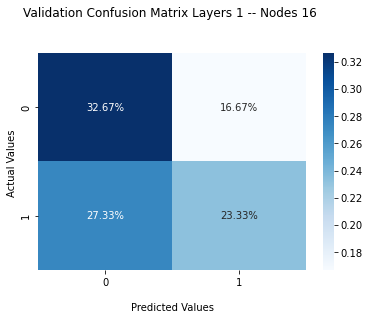

CPU times: user 1min 2s, sys: 5.81 s, total: 1min 7s
Wall time: 1min 13s


In [ ]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(1, 16)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 1
Number of nodes in each hidden layer: 12
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_47 (Dense)            (None, 8)                 24        
                                                                 
 dense_48 (Dense)            (None, 12)                108       
                                                                 
 dense_49 (Dense)            (None, 1)                 13        
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2'], dtype='object')
Training model...
Epoch 1/1000
8/8 [==============================] - 1s 28ms/step - loss: 1.5573 - accuracy: 0.4815 - val_loss: 1.4542 - val_accuracy: 0.4952
Epoch 2/1000
8/8 

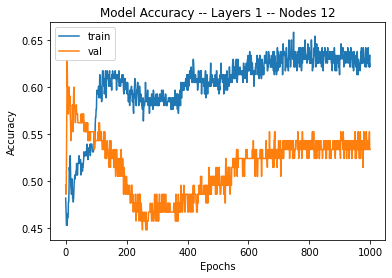

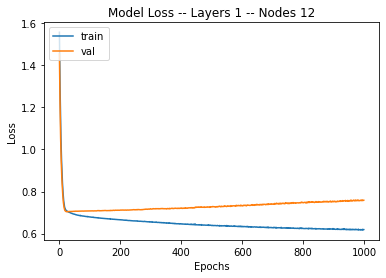

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.50      0.43      0.46        82
           1       0.41      0.49      0.45        68

    accuracy                           0.45       150
   macro avg       0.46      0.46      0.45       150
weighted avg       0.46      0.45      0.45       150



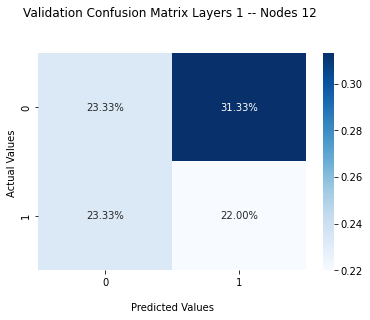

CPU times: user 1min 2s, sys: 5.8 s, total: 1min 8s
Wall time: 1min 23s


In [ ]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(1, 12)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 1
Number of nodes in each hidden layer: 8
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 8)                 24        
                                                                 
 dense_51 (Dense)            (None, 8)                 72        
                                                                 
 dense_52 (Dense)            (None, 1)                 9         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2'], dtype='object')
Training model...
Epoch 1/1000
8/8 [==============================] - 1s 27ms/step - loss: 1.3941 - accuracy: 0.5144 - val_loss: 1.5099 - val_accuracy: 0.4857
Epoch 2/1000
8/8 [

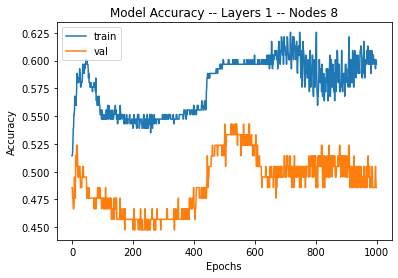

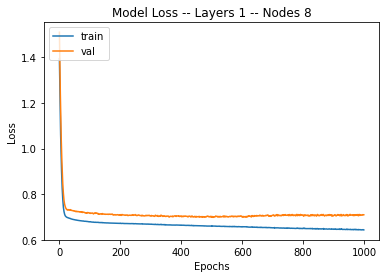

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.60      0.48      0.53        77
           1       0.55      0.66      0.60        73

    accuracy                           0.57       150
   macro avg       0.57      0.57      0.56       150
weighted avg       0.57      0.57      0.56       150



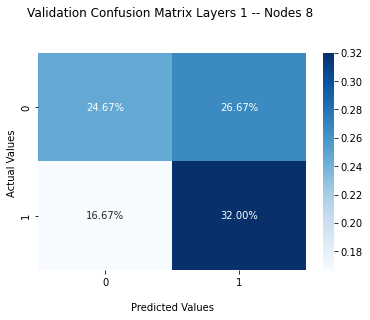

CPU times: user 1min 1s, sys: 5.69 s, total: 1min 7s
Wall time: 1min 23s


In [ ]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(1, 8)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 1
Number of nodes in each hidden layer: 4
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_53 (Dense)            (None, 8)                 24        
                                                                 
 dense_54 (Dense)            (None, 4)                 36        
                                                                 
 dense_55 (Dense)            (None, 1)                 5         
                                                                 
Total params: 65
Trainable params: 65
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2'], dtype='object')
Training model...
Epoch 1/1000
8/8 [==============================] - 1s 26ms/step - loss: 0.9840 - accuracy: 0.5185 - val_loss: 1.0038 - val_accuracy: 0.5333
Epoch 2/1000
8/8 [==

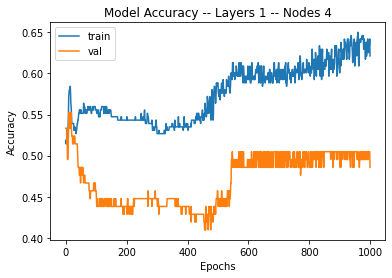

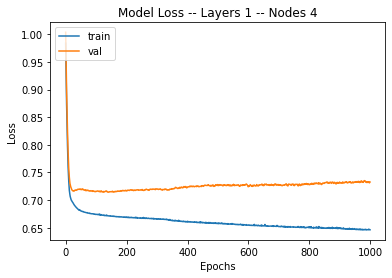

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.51      0.45      0.48        76
           1       0.49      0.55      0.52        74

    accuracy                           0.50       150
   macro avg       0.50      0.50      0.50       150
weighted avg       0.50      0.50      0.50       150



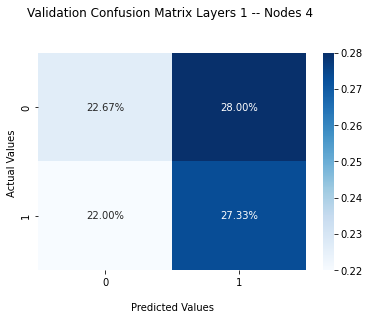

CPU times: user 1min 2s, sys: 5.49 s, total: 1min 7s
Wall time: 1min 23s


In [ ]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(1, 4)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

3. Visually observe the dataset and design an appropriate feature transformation (derived feature) such that after feature transformation, the dataset can be classified using a minimal network architecture (minimum number of parameters). 
* Design, train this minimal network, and report training and validation errors, and trained parameters of the network. 
* Use 70% training and 30% validation data, appropriate learning rate, activation and loss functions. 
* Explain the final results. [1+1+0.5 marks]

In [8]:
def make_features(data):
  """
  This function will add new features to the dataset
  data -> pd.DataFrame : original data

  return -> pd.DataFrame
  """
  data['X1_sq'] = data['X1'].apply(np.square, axis=1)
  data['X2_sq'] = data['X2'].apply(np.square, axis=1)
  data['X1sq_X2sq'] = data['X1_sq'] + data['X2_sq']
  data['r'] = data.apply(lambda x: np.sqrt(x['X1sq_X2sq']), axis=1)
  data['theta'] = data.apply(lambda x: np.arctan2(x['X1'], x['X2']), axis=1)

  return data

In [9]:
feat_df = make_features(df)
feat_df

,X1,X2,class,X1_sq,X2_sq,X1sq_X2sq,r,theta
0,0.156327,1.185676e-02,0,0.024438,1.405826e-04,0.024579,0.156776,1.495095
1,0.211109,3.220876e-02,0,0.044567,1.037404e-03,0.045604,0.213552,1.419394
2,0.263386,6.086580e-02,0,0.069372,3.704646e-03,0.073077,0.270327,1.343693
3,0.312221,9.754146e-02,0,0.097482,9.514336e-03,0.106996,0.327103,1.267992
4,0.356707,1.418555e-01,0,0.127240,2.012297e-02,0.147363,0.383879,1.192291
...,...,...,...,...,...,...,...,...
493,-13.181762,4.118132e+00,1,173.758851,1.695901e+01,190.717864,13.810064,-1.267992
494,-13.510777,3.122201e+00,1,182.541100,9.748141e+00,192.289241,13.866840,-1.343693
495,-13.764337,2.100020e+00,1,189.456984,4.410082e+00,193.867066,13.923615,-1.419394
496,-13.940352,1.057319e+00,1,194.333413,1.117924e+00,195.451337,13.980391,-1.495095


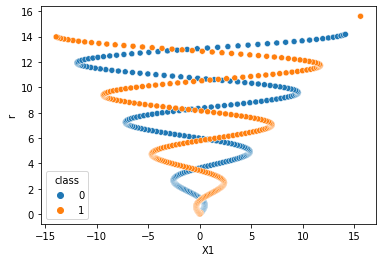

In [ ]:
# This gives a side-view of the spiral distribution
sns.scatterplot(x="X1", y="r", data=feat_df, hue="class")

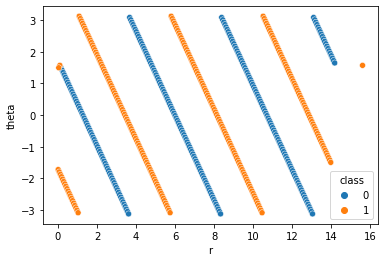

In [ ]:
# this gives a linearly seperable distribution of the target class
sns.scatterplot(x="r", y="theta", data=feat_df, hue="class")

Number of hidden layers: 2
Number of nodes in each hidden layer: 16
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8)                 64        
                                                                 
 dense_5 (Dense)             (None, 16)                144       
                                                                 
 dense_6 (Dense)             (None, 16)                272       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2', 'X1_sq', 'X2_sq', 'X1sq_X2sq', 'r', 'theta'], dtype='object')


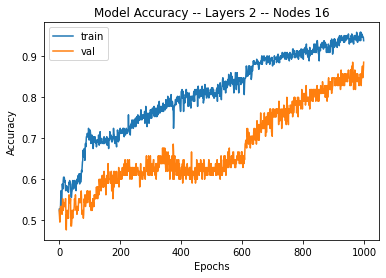

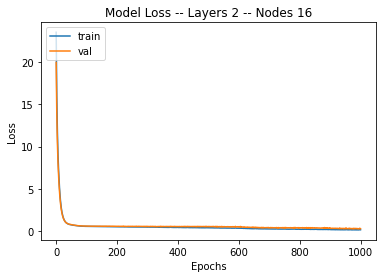

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.91      0.85      0.88        86
           1       0.81      0.89      0.85        64

    accuracy                           0.87       150
   macro avg       0.86      0.87      0.87       150
weighted avg       0.87      0.87      0.87       150



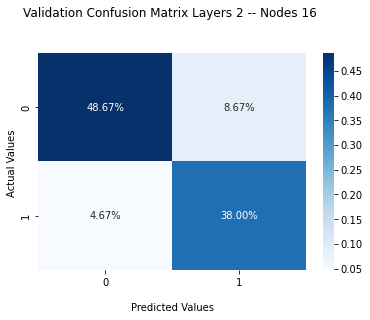

CPU times: user 1min 11s, sys: 6.34 s, total: 1min 18s
Wall time: 1min 25s


In [10]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(2, 16, transform=True)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(feat_df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 2
Number of nodes in each hidden layer: 12
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 8)                 64        
                                                                 
 dense_9 (Dense)             (None, 12)                108       
                                                                 
 dense_10 (Dense)            (None, 12)                156       
                                                                 
 dense_11 (Dense)            (None, 1)                 13        
                                                                 
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2', 'X1_sq', 'X2_sq', 'X1sq_X2sq', 'r', 'theta'], dtype='object')


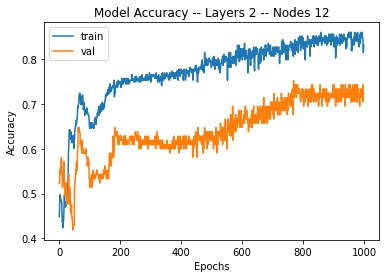

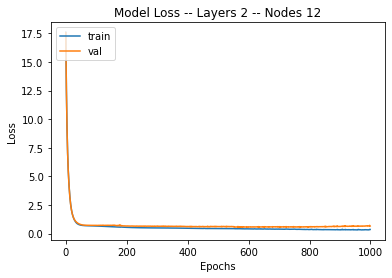

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.63      0.64      0.64        76
           1       0.62      0.61      0.62        74

    accuracy                           0.63       150
   macro avg       0.63      0.63      0.63       150
weighted avg       0.63      0.63      0.63       150



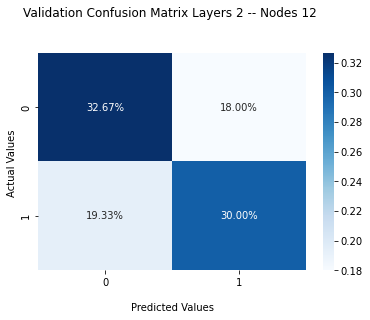

CPU times: user 1min 10s, sys: 6.23 s, total: 1min 16s
Wall time: 1min 21s


In [11]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(2, 12, transform=True)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(feat_df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 2
Number of nodes in each hidden layer: 8
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 8)                 64        
                                                                 
 dense_13 (Dense)            (None, 8)                 72        
                                                                 
 dense_14 (Dense)            (None, 8)                 72        
                                                                 
 dense_15 (Dense)            (None, 1)                 9         
                                                                 
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2', 'X1_sq', 'X2_sq', 'X1sq_X2sq', 'r', 'theta'], dtype='object')
T

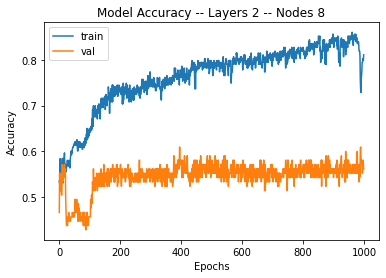

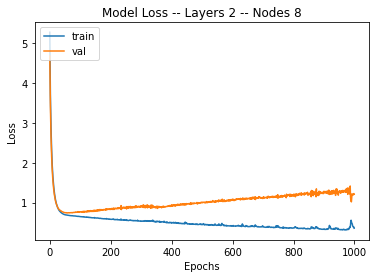

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.58      0.71      0.64        75
           1       0.63      0.49      0.55        75

    accuracy                           0.60       150
   macro avg       0.60      0.60      0.60       150
weighted avg       0.60      0.60      0.60       150



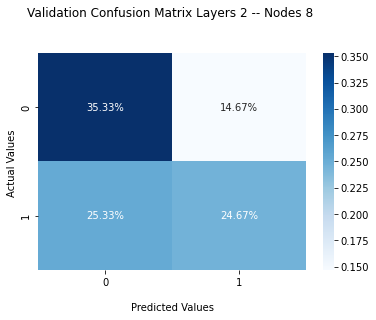

CPU times: user 1min 9s, sys: 6.28 s, total: 1min 15s
Wall time: 1min 23s


In [12]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(2, 8, transform=True)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(feat_df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 2
Number of nodes in each hidden layer: 4
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 8)                 64        
                                                                 
 dense_17 (Dense)            (None, 4)                 36        
                                                                 
 dense_18 (Dense)            (None, 4)                 20        
                                                                 
 dense_19 (Dense)            (None, 1)                 5         
                                                                 
Total params: 125
Trainable params: 125
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2', 'X1_sq', 'X2_sq', 'X1sq_X2sq', 'r', 'theta'], dtype='object')
T

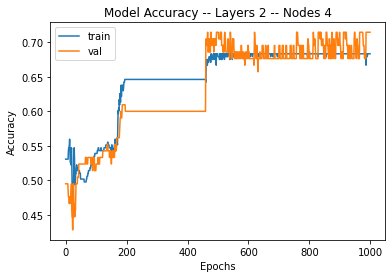

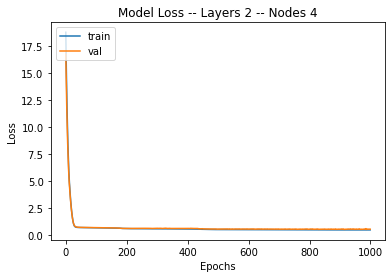

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.65      0.98      0.78        81
           1       0.93      0.38      0.54        69

    accuracy                           0.70       150
   macro avg       0.79      0.68      0.66       150
weighted avg       0.78      0.70      0.67       150



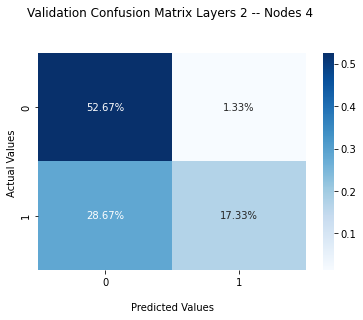

CPU times: user 1min 11s, sys: 6.22 s, total: 1min 17s
Wall time: 1min 27s


In [13]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(2, 4, transform=True)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(feat_df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 1
Number of nodes in each hidden layer: 16
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 8)                 64        
                                                                 
 dense_21 (Dense)            (None, 16)                144       
                                                                 
 dense_22 (Dense)            (None, 1)                 17        
                                                                 
Total params: 225
Trainable params: 225
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2', 'X1_sq', 'X2_sq', 'X1sq_X2sq', 'r', 'theta'], dtype='object')
Training model...
Epoch 1/1000
8/8 [==============================] - 1s 27ms/step - loss: 13.8238 - accuracy: 0.4650 - val_loss: 11

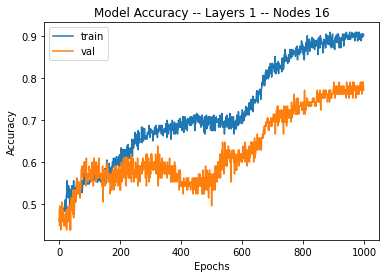

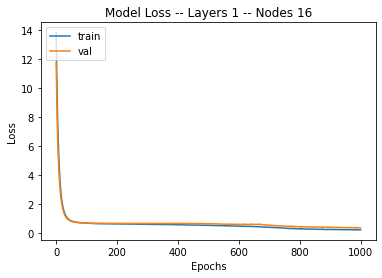

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.81      0.78      0.79        77
           1       0.78      0.81      0.79        73

    accuracy                           0.79       150
   macro avg       0.79      0.79      0.79       150
weighted avg       0.79      0.79      0.79       150



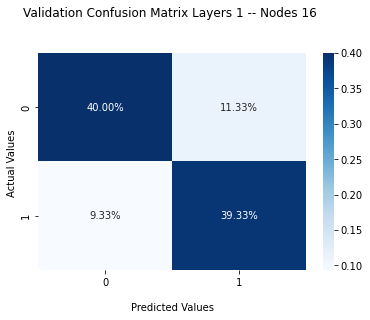

CPU times: user 1min 7s, sys: 5.78 s, total: 1min 13s
Wall time: 1min 21s


In [14]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(1, 16, transform=True)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(feat_df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 1
Number of nodes in each hidden layer: 12
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 8)                 64        
                                                                 
 dense_24 (Dense)            (None, 12)                108       
                                                                 
 dense_25 (Dense)            (None, 1)                 13        
                                                                 
Total params: 185
Trainable params: 185
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2', 'X1_sq', 'X2_sq', 'X1sq_X2sq', 'r', 'theta'], dtype='object')
Training model...
Epoch 1/1000
8/8 [==============================] - 1s 27ms/step - loss: 24.9718 - accuracy: 0.5062 - val_loss: 21

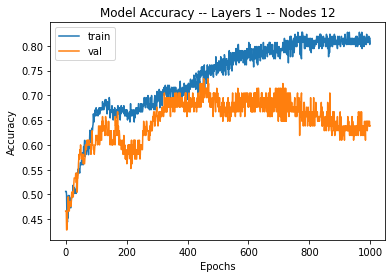

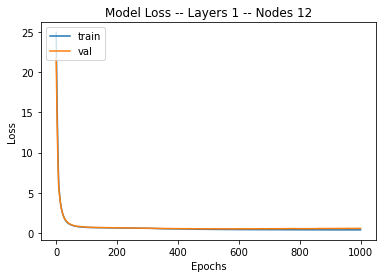

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.61      0.70      0.65        76
           1       0.63      0.54      0.58        74

    accuracy                           0.62       150
   macro avg       0.62      0.62      0.62       150
weighted avg       0.62      0.62      0.62       150



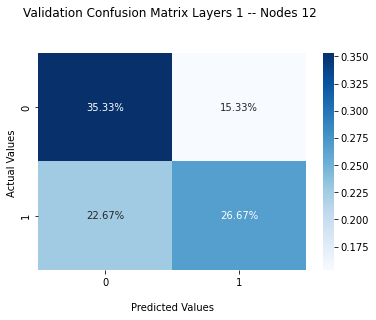

CPU times: user 1min 6s, sys: 5.77 s, total: 1min 12s
Wall time: 1min 18s


In [15]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(1, 12, transform=True)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(feat_df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 1
Number of nodes in each hidden layer: 8
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 8)                 64        
                                                                 
 dense_27 (Dense)            (None, 8)                 72        
                                                                 
 dense_28 (Dense)            (None, 1)                 9         
                                                                 
Total params: 145
Trainable params: 145
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2', 'X1_sq', 'X2_sq', 'X1sq_X2sq', 'r', 'theta'], dtype='object')
Training model...
Epoch 1/1000
8/8 [==============================] - 1s 28ms/step - loss: 20.5514 - accuracy: 0.5021 - val_loss: 26.

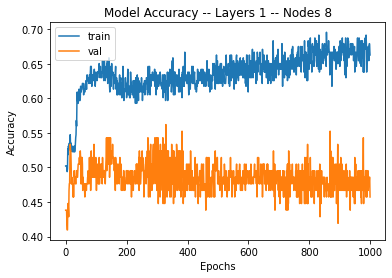

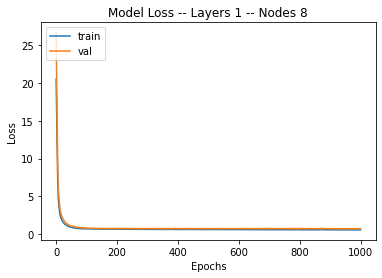

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.56      0.56      0.56        80
           1       0.50      0.50      0.50        70

    accuracy                           0.53       150
   macro avg       0.53      0.53      0.53       150
weighted avg       0.53      0.53      0.53       150



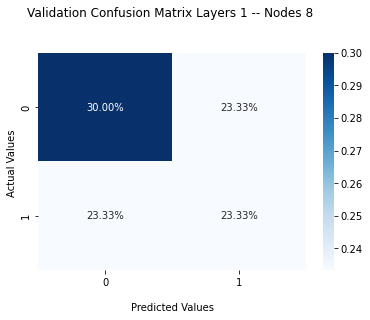

CPU times: user 1min 7s, sys: 5.75 s, total: 1min 13s
Wall time: 1min 23s


In [16]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(1, 8, transform=True)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(feat_df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

Number of hidden layers: 1
Number of nodes in each hidden layer: 4
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_29 (Dense)            (None, 8)                 64        
                                                                 
 dense_30 (Dense)            (None, 4)                 36        
                                                                 
 dense_31 (Dense)            (None, 1)                 5         
                                                                 
Total params: 105
Trainable params: 105
Non-trainable params: 0
_________________________________________________________________
None
Preparing dataset...
Features are:Index(['X1', 'X2', 'X1_sq', 'X2_sq', 'X1sq_X2sq', 'r', 'theta'], dtype='object')
Training model...
Epoch 1/1000
8/8 [==============================] - 1s 27ms/step - loss: 16.8505 - accuracy: 0.4897 - val_loss: 15.

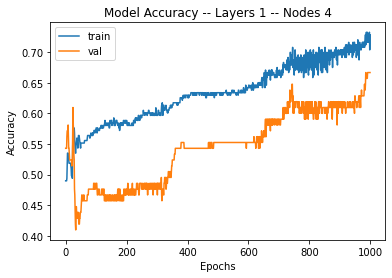

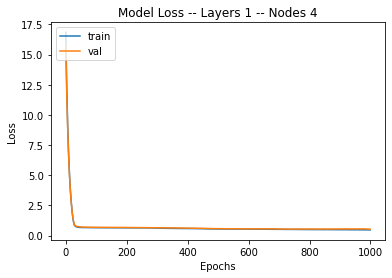

Running predictions...

 Validation Classification Report
               precision    recall  f1-score   support

           0       0.82      0.46      0.59        72
           1       0.65      0.91      0.76        78

    accuracy                           0.69       150
   macro avg       0.74      0.68      0.67       150
weighted avg       0.73      0.69      0.68       150



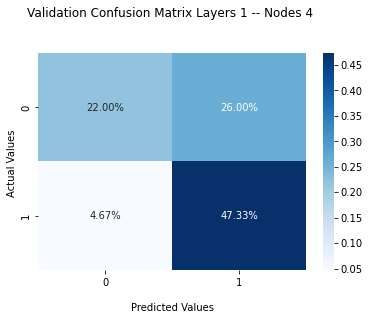

CPU times: user 1min 6s, sys: 5.81 s, total: 1min 12s
Wall time: 1min 23s


In [17]:
%%time
# Program starts from here
  
# intialising model
modm = ModelMaker(1, 4, transform=True)

# preparing dataset
X_train, X_val, y_train, y_val = modm.prepare_data(feat_df)

# training model
modm.train_model(X_train, y_train)

# running predictions
preds = modm.predict(X_val, y_val)

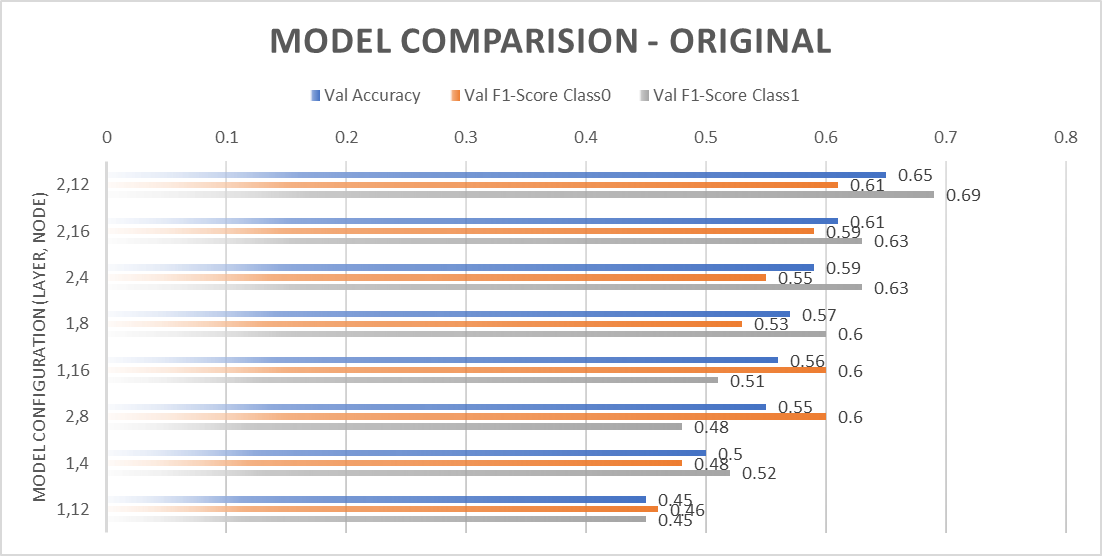

### It can be observed more complex networks are performing better than simple single hidden layer perceptrons

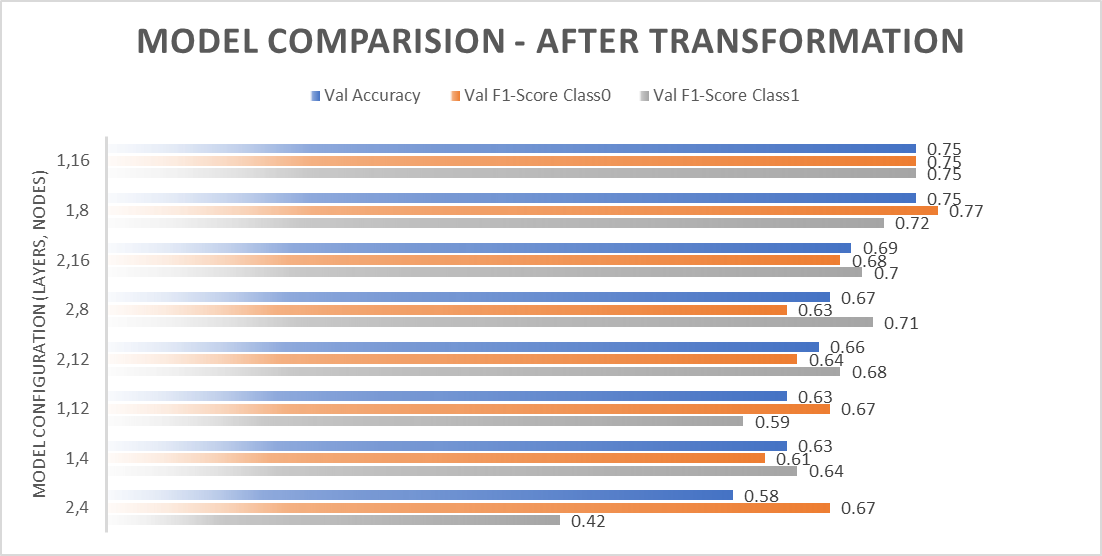

##### Surpisingly ! After the feature transformation it can be observed that simpler networks are able to beat their complex counterparts

### Conclusion

#### It can be thus concluded that good network design along with robust feature engineering can outperform more complex networks